In [1]:
%matplotlib inline

import os
import math
import h5py
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from astropy.table import Table
from collections import namedtuple
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook as tqdm

In [2]:
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [3]:
def plot(wave, flux):
    plt.plot(wave, flux)
    plt.axvline(target_lb, color='r', linestyle='--')
    plt.axvline(target_ub, color='r', linestyle='--')
    plt.axvline(latent_lb, color='r', linestyle='--')
    plt.axvline(latent_ub, color='r', linestyle='--')
    plt.show()

In [4]:
def round_value(x, to, up=True):
    if up:
        return int(math.ceil(x/to))*to
    else:
        return int(math.floor(x/to))*to

In [5]:
def interpolate(wave, flux):
    interp = interp1d(wave, flux, kind='cubic')
    lb = round_value(wave[0], resolution, up=True)
    ub = round_value(wave[-1], resolution, up=False)
    x = np.arange(lb, ub, resolution)
    y = interp(x)
    return x, y

In [6]:
z_lb = 2.09
z_ub = 2.51

target_lb = 1180
target_ub = 1280

latent_lb = 1280
latent_ub = 2280

snr_wave = 1290
snr_range = 2.5

norm_wave = 1290
norm_range = 2.5

resolution = 0.25
snr_threshold = 5.0

In [7]:
filename = '/vol/data/spectralgan/IGMspec_DB_v03.hdf5'
group_key = 'BOSS_DR14'

In [8]:
Datum = namedtuple('Datum', ['latent', 'target', 'shift'])

In [9]:
f = h5py.File(filename, 'r')
data = f[group_key]
specs = data['spec']

In [10]:
meta_table = Table.read(filename, path=group_key+'/meta')

In [11]:
train_data = []

for i, spec in tqdm(enumerate(specs), total=len(specs)):
    
    if not meta_table[i]['ZWARNING']:
        z = meta_table[i]['Z']
        
        if z_lb < z < z_ub:
            wave, flux = spec['wave'], spec['flux']
            wave, flux =  wave[wave != 0], flux[wave != 0]
            wave /= z + 1
            
            if wave[0] < target_lb and wave[-1] > latent_ub:
                fl = flux[(wave >= snr_wave-snr_range) & (wave < snr_wave+snr_range)]

                if np.median(fl)/np.std(fl) > snr_threshold:
                    wave, flux = interpolate(wave, flux)
                    
                    latent = flux[(wave >= latent_lb) & (wave < latent_ub)]
                    target = flux[(wave >= target_lb) & (wave < target_ub)]
                    
                    # Normalize latent with modified Z-score and target to [-1, 1]
                    a, b = np.median(latent), latent.std()
                    latent = (latent - a)/(b)
                    
                    c, d = target.min(), target.max()
                    target = 2*((target - c)/(d - c)) - 1

                    train_data.append(Datum(latent, target, [a, b, c, d]))

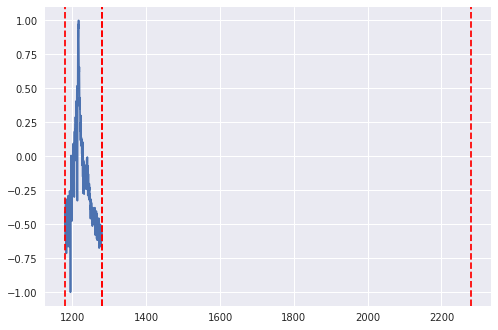

In [16]:
plot(np.arange(1180, 1280, 0.25), train_data[2].target)

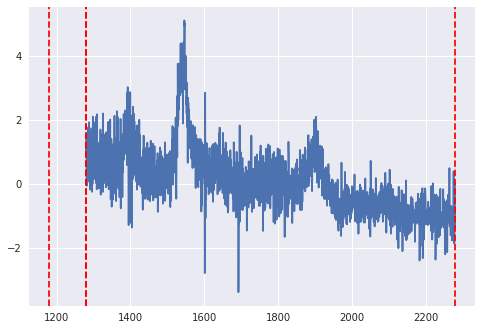

In [24]:
plot(np.arange(1280, 2280, 0.25), train_data[6].latent)

In [12]:
def np_to_tfrecords(X, Y, Z, file_path_prefix, verbose=False):
    def _dtype_feature(ndarray):
        """match appropriate tf.train.Feature class with dtype of ndarray. """
        assert isinstance(ndarray, np.ndarray)
        dtype_ = ndarray.dtype
        if dtype_ == np.float64 or dtype_ == np.float32:
            return lambda array: tf.train.Feature(float_list=tf.train.FloatList(value=array))
        elif dtype_ == np.int64 or dtype_ == np.int32:
            return lambda array: tf.train.Feature(int64_list=tf.train.Int64List(value=array))
        else:  
            raise ValueError("The input should be numpy ndarray. \
                               Instead got {}".format(ndarray.dtype))
            
    assert isinstance(X, np.ndarray)
    assert len(X.shape) == 2  # If X has a higher rank, 
                              # it should be reshaped before fed to this function.
    assert isinstance(Y, np.ndarray) or Y is None
    
    # load appropriate tf.train.Feature class depending on dtype
    dtype_feature_x = _dtype_feature(X)
    if Y is not None:
        assert X.shape[0] == Y.shape[0]
        assert len(Y.shape) == 2
        dtype_feature_y = _dtype_feature(Y)
    if Z is not None:
        assert X.shape[0] == Z.shape[0]
        assert len(Z.shape) == 2
        dtype_feature_z = _dtype_feature(Z)
    
    # Generate tfrecord writer
    result_tf_file = file_path_prefix + '.tfrecords'
    writer = tf.python_io.TFRecordWriter(result_tf_file)
    if verbose:
        print("Serializing {:d} examples into {}".format(X.shape[0], result_tf_file))
        
    # iterate over each sample,
    # and serialize it as ProtoBuf.
    for idx in range(X.shape[0]):
        x = X[idx]
        if Y is not None:
            y = Y[idx]
        if Z is not None:
            z = Z[idx]
        
        d_feature = {}
        d_feature['latent'] = dtype_feature_x(x)
        if Y is not None:
            d_feature['target'] = dtype_feature_y(y)
        if Z is not None:
            d_feature['metadata'] = dtype_feature_z(z)
            
        features = tf.train.Features(feature=d_feature)
        example = tf.train.Example(features=features)
        serialized = example.SerializeToString()
        writer.write(serialized)
    
    if verbose:
        print("Writing {} done!".format(result_tf_file))

In [13]:
savedir = '/vol/data/spectralgan/train'

In [16]:
batches = 40
test_idx = np.random.choice(batches, size=batches//10, replace=False)
batch_size = len(train_data)//batches

for i in tqdm(range(batches)):
    batch = train_data[batch_size*i:batch_size*(i+1)]

    batch = Datum(*zip(*batch))
    
    latent = np.vstack(batch.latent)
    target = np.vstack(batch.target)
    shift = np.vstack(batch.shift)
    
    if i in test_idx:
        np_to_tfrecords(latent, target, shift, os.path.join(savedir, 'test_{}'.format(i)))
    else:
        np_to_tfrecords(latent, target, shift, os.path.join(savedir, 'train_{}'.format(i)))

In [17]:
test_idx

array([37, 28, 16,  8])

In [18]:
len(train_data)

41160